In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import pickle
import argparse
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
import sys
import datetime
from pathlib import Path
import seaborn as sns
import time
from Bio import SeqIO
from torch.utils.data import DataLoader
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from config import *
import util.misc as utils
from models.nt_classifier import build as build_model
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


### Paris only hardneg not containing regions of interaction from scratch

In [98]:
def load_sample_from_chunk(file_swap_neg, chunksize = 1_000_000, n_count_max = 5, n_samples = 500_000):
    
    count=0
    
    for chunk in pd.read_csv(file_swap_neg,chunksize=chunksize,sep="\t"):    
        if count == 0:
            subset_filtered=chunk.copy(deep=True)
        else:
            subset_filtered=subset_filtered.append(chunk)

        count+=1

        if count == n_count_max:
            break
        
        
    subset_filtered = subset_filtered.sample(n_samples).reset_index(drop = True)
    
    return subset_filtered

def read_and_concatenate_bed_files_paris(directory, list_of_files_to_load, list_of_names, n_samples):
    # List to store individual dataframes
    dataframes = []
    
    # Iterate over all files in the directory
    for _, filename in enumerate(list_of_files_to_load):
        
        
        file_path = os.path.join(directory, filename)
        
        # Read the .bed file into a dataframe
        if 'NegativeBySwap' in filename:
            df = load_sample_from_chunk(file_path, n_samples = n_samples)
        else:
            df = pd.read_csv(file_path, sep='\t')
            print(df.shape[0])

        # Check and rename columns if necessary
        if 'chrom_1' in df.columns and 'chrom_2' in df.columns:
            df = df.rename(columns={'chrom_1': 'emb_name_1', 'chrom_2': 'emb_name_2'})
            
            
        df['id_pair'] = df['emb_name_1'] + '+' + df['emb_name_2'] + '+' + df['start_1'].astype(str) + '+' + df['end_1'].astype(str) + '+' + df['start_2'].astype(str) + '+' + df['end_2'].astype(str)
        
        
        df = df.rename(columns={
            'emb_name_1': 'embedding1name', 
            'emb_name_2': 'embedding2name',
            'start_1': 'start_window1',
            'end_1': 'end_window1',
            'start_2': 'start_window2',
            'end_2': 'end_window2',
        })
        
        dataframes.append(df)
    
    # Concatenate all dataframes into one
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    
    concatenated_df = concatenated_df.drop('Unnamed: 0', axis = 1) 
    
    concatenated_df = concatenated_df.drop_duplicates()

    # devo droppare tutti quelli che non iniziano per ens
    concatenated_df['ens_gene'] = concatenated_df['embedding1name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)

    concatenated_df['ens_gene'] = concatenated_df['embedding2name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)
    
    return concatenated_df

In [292]:
import random
def find_possible_interval(rna1_coords, len_rna1):
    max_interval_length = len_rna1  # min(5970, len_rna1)

    # Add boundaries to the list of coordinates
    extended_coords = [(0, -1)] + sorted(rna1_coords) + [(len_rna1, len_rna1 + 1)]

    # Initialize variables to keep track of the largest interval
    largest_interval_start = 0
    largest_interval_end = 0
    largest_interval_length = 0

    # Iterate through the sorted coordinates to find the gaps
    for i in range(len(extended_coords) - 1):
        current_end = extended_coords[i][1]
        next_start = extended_coords[i + 1][0]

        # Calculate the gap between the current end and the next start
        gap_start = current_end + 1
        gap_end = next_start - 1
        gap_length = gap_end - gap_start + 1

        # Check if this gap is the largest found so far and within the max limit
        if gap_length > largest_interval_length and gap_length <= max_interval_length:
            largest_interval_start = gap_start
            largest_interval_end = gap_end
            largest_interval_length = gap_length

    # The interval should be [largest_interval_start, largest_interval_end]
    # But to ensure it is within the allowed maximum length
    if largest_interval_length > max_interval_length:
        largest_interval_end = largest_interval_start + max_interval_length - 1

    largest_interval = (largest_interval_start, largest_interval_end)
    return largest_interval

def find_random_interval(start, end, max_length):
    # Calculate the length of the input interval
    length_of_input_interval = end - start
    # Calculate the maximum possible length for the random interval
    max_interval_length = min(max_length, length_of_input_interval)
    
    # Generate a random starting point
    random_start = random.randint(start, end - max_interval_length)
    # Calculate the ending point of the interval
    random_end = random_start + max_interval_length
    
    return (random_start, random_end)

def find_hardneg_window(rna_coords, len_rna):
    interval = find_possible_interval(rna_coords, len_rna)
    return find_random_interval(interval[0], interval[1], 5970)

In [293]:
filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.bedpe')

rows = []
with open(filename)as f:
    for line in f:
        L = line.strip().split()
        rows.append(L)

all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )
all_interactions[['x1', 'x2', 'y1', 'y2']] = all_interactions[['x1', 'x2', 'y1', 'y2']].apply(pd.to_numeric)

#they are already mapped so the strand should be always '+'
assert (all_interactions.strand1 == all_interactions.strand2).all()
assert set(all_interactions.strand1) == {'+'}
all_interactions = all_interactions.drop(['strand1', 'strand2'], axis = 1)

paris_experiments = ['hs_PARIS1__Hela_highRNase', 'mm_PARIS2__GSM4503873_Mouse_brain_mRNA', 'hs_PARIS1__Hela_lowRNase', 'hs_PARIS1__HEK293T', 'hs_PARIS2__GSM4503872_HEK293_mRNA', 'mm_PARIS1__mES', 'hs_PARIS2__HEK293_AMT', 'hs_PARIS2__HEK293_Amoto']
mario_experiments = ['mm_MARIO__mES']
ricseq_experiments = ['hs_RIC-seq__HeLa_merge.InterGene.arms']
ricseq_exp = all_interactions[all_interactions.experiment.isin(ricseq_experiments)].reset_index(drop = True)

In [294]:
ricseq_exp['couple'] = ricseq_exp['tr1'] + '_' + ricseq_exp['tr2']

ricseq_exp['couple_swap'] = ricseq_exp['tr2'] + '_' + ricseq_exp['tr1']
to_drop = set(ricseq_exp[ricseq_exp['couple'].isin(set(ricseq_exp['couple_swap'] ))].couple)
ricseq_exp = ricseq_exp[~ricseq_exp.couple.isin(to_drop)]
ricseq_exp = ricseq_exp.drop('couple_swap', axis = 1)

# 2 or more reads
ricseq_exp = ricseq_exp[ricseq_exp.n_reads.astype(int)>1]

In [295]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes.csv'))

In [296]:
list_of_pos_couples = set(ricseq_exp.couple)

In [317]:
diz = {}
idx=0

for couple in tqdm(list_of_pos_couples):
    
    all_interactions = ricseq_exp[ricseq_exp.couple == couple]

    rna1_coords = []
    rna2_coords = []

    for _, row in all_interactions.iterrows():
        rna1_coords.append((row.x1, row.x2))
        rna2_coords.append((row.y1, row.y2))

    len_rna1 = df_genes[df_genes.ensembl_transcript_id == row.tr1].length.iloc[0]
    len_rna2 = df_genes[df_genes.ensembl_transcript_id == row.tr2].length.iloc[0]

    
    if (len_rna1>8_000)&(len_rna2>8_000):
        n_iters = 3
    else:
        n_iters = 1
        
    for i in range(n_iters):
        embedding1_interval = find_hardneg_window(rna1_coords, len_rna1)
        emb_length1 = embedding1_interval[1] - embedding1_interval[0]

        embedding2_interval = find_hardneg_window(rna2_coords, len_rna2)
        emb_length2 = embedding2_interval[1] - embedding2_interval[0]

        if (emb_length1>550) & (emb_length2>550): # I calculate only if the embedding has at least length of 550

            x1, x2 = find_random_interval(0, emb_length1, 500)
            y1, y2 = find_random_interval(0, emb_length2, 500)

            diz[idx] = {'couple': couple, 
                        'transcript1':row.tr1,
                        'transcript2':row.tr2,
                        'start_emb1':embedding1_interval[0],
                        'end_emb1':embedding1_interval[1],
                        'x1':x1,
                        'x2':x2,
                        'start_emb2':embedding2_interval[0],
                        'end_emb2':embedding2_interval[1],
                        'y1':y1,
                        'y2':y2,
                        'original_len1':len_rna1,
                        'original_len2':len_rna2,
                       }

            idx+=1

  0%|          | 0/9105 [00:00<?, ?it/s]

In [318]:
hn = pd.DataFrame.from_dict(diz, orient = 'index')

In [319]:
diz = {}
for idx, row in tqdm(hn.iterrows(), total = hn.shape[0]):
    tr1, tr2 = row.transcript1, row.transcript2
    x1,x2,y1,y2 = row.start_emb1, row.end_emb1, row.start_emb2, row.end_emb2

    all_interactions = ricseq_exp[(ricseq_exp['tr1'] == tr1)&(ricseq_exp['tr2'] == tr2)]
    assert all_interactions.shape[0] > 0

    distances_x = []
    distances_y = []
    for _, df_row in all_interactions.iterrows():
        distances_x.append(
            min_distance([x1,x2], [df_row.x1,df_row.x2])
        )
        distances_y.append(
            min_distance([y1,y2], [df_row.y1,df_row.y2])
        )

    distance_x = min(distances_x)
    distance_y = min(distances_y)
    
    diz[idx] = {'distance_x':distance_x, 'distance_y':distance_y}

  0%|          | 0/9592 [00:00<?, ?it/s]

In [372]:
distances = pd.DataFrame.from_dict(diz, orient = 'index')
final_hn = pd.concat([hn, distances], axis = 1)

In [373]:
wrong=final_hn[((final_hn.distance_x>0) & (final_hn.distance_y>0)) == False]
# sono solo 7, shalla
wrong.shape[0]

7

In [374]:
final_hn = final_hn[((final_hn.distance_x>0) & (final_hn.distance_y>0)) == True].reset_index(drop = True)

In [375]:
final_hn[(final_hn.distance_x>200)&(final_hn.distance_y>200)].shape[0]

819

In [376]:
#sono tutte 500 X 500
(final_hn.x2-final_hn.x1).min() == (final_hn.x2-final_hn.x1).max() == (final_hn.y2-final_hn.y1).min() == 500

True

In [377]:
assert (final_hn.end_emb1-final_hn.start_emb1).max() == (final_hn.end_emb2-final_hn.start_emb2).max() == 5970

In [378]:
(final_hn.end_emb1-final_hn.start_emb1).min(), (final_hn.end_emb2-final_hn.start_emb2).min() 

(552, 551)

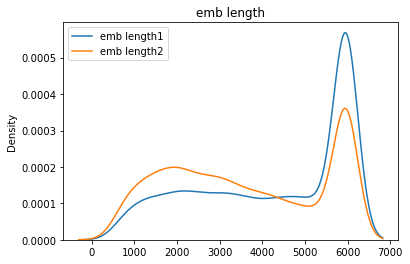

In [379]:
plt.title('emb length')
sns.kdeplot(data=list(final_hn.end_emb1-final_hn.start_emb1), label = 'emb length1')
sns.kdeplot(data=list(final_hn.end_emb2-final_hn.start_emb2), label = 'emb length2')
plt.legend()

In [380]:
final_hn['id_pair'] = final_hn.index

In [381]:
check_data_path = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/my_check_predictions_ricseq'
embedding_dir = os.path.join(check_data_path, 'embeddings')

In [382]:
final_hn['embedding1name'] = final_hn.transcript1 + '_' + final_hn.start_emb1.astype(str) + '_' + final_hn.end_emb1.astype(str)
final_hn['embedding2name'] = final_hn.transcript2 + '_' + final_hn.start_emb2.astype(str) + '_' + final_hn.end_emb2.astype(str)

In [383]:
final_hn = final_hn.rename(columns={
            'x1': 'start_window1',
            'x2': 'end_window1',
            'y1': 'start_window2',
            'y2': 'end_window2',
        })

In [384]:
final_hn.to_csv(os.path.join(check_data_path, 'df_hn.csv'), index = False)

In [404]:
pairs = final_hn[['embedding1name', 'embedding2name','id_pair', 'start_window1', 'end_window1', 'start_window2', 'end_window2']]
pairs.to_csv(os.path.join(check_data_path, 'pairs.csv'), index = False)

#### creo df_query

In [397]:
idx = 0
diz_q = {}
for _, row in final_hn.iterrows():
    
    cdna1 = df_genes[df_genes.ensembl_transcript_id == row.transcript1].cdna.iloc[0]
    cdna1 = cdna1[row.start_emb1: row.end_emb1]
    
    cdna2 = df_genes[df_genes.ensembl_transcript_id == row.transcript2].cdna.iloc[0]
    cdna2 = cdna2[row.start_emb2: row.end_emb2]
    
    
    assert len(cdna1) == row.end_emb1 - row.start_emb1
    assert len(cdna2) == row.end_emb2 - row.start_emb2
    
    
    diz_q[idx] = {
        'id_query': row.embedding1name, 
        'cdna': cdna1
    }
    idx +=1
    
    diz_q[idx] = {
        'id_query': row.embedding2name, 
        'cdna': cdna2
    }
    idx +=1

In [398]:
df_query = pd.DataFrame.from_dict(diz_q, orient = 'index')
df_query = df_query.drop_duplicates().reset_index(drop = True)

In [401]:
def estimate_time_and_space(n_samples):
    #TIME
    minutes = 3219*n_samples/(228278)
    hours = minutes/60
    days = hours/24
    print('estimated # hours:', np.round(hours, 2))
    print('estimated # days:', np.round(days, 2))

    mb = 10.2*n_samples
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (pessimistic):', np.round(tb, 2))
    mb = 1995*n_samples/(300)
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (realistic):', np.round(tb, 2))
estimate_time_and_space(df_query.shape[0])

estimated # hours: 4.33
estimated # days: 0.18
estimated terabytes (pessimistic): 0.19
estimated terabytes (realistic): 0.12


In [402]:
df_query.to_csv(os.path.join(check_data_path, f'embedding_query.csv'), index = False)

In [408]:
assert set(df_query.id_query) == set(pairs.embedding1name).union(pairs.embedding2name)

# Qui script dove faccio import dei file di Adri

### Paris only hardneg not containing regions of interaction, from adri files

In [34]:
def load_sample_from_chunk(file_swap_neg, chunksize = 1_000_000, n_count_max = 5, n_samples = 500_000):
    
    count=0
    
    for chunk in pd.read_csv(file_swap_neg,chunksize=chunksize,sep="\t"):    
        if count == 0:
            subset_filtered=chunk.copy(deep=True)
        else:
            subset_filtered=subset_filtered.append(chunk)

        count+=1

        if count == n_count_max:
            break
        
        
    subset_filtered = subset_filtered.sample(n_samples).reset_index(drop = True)
    
    return subset_filtered

def read_and_concatenate_bed_files_paris(directory, list_of_files_to_load, list_of_names, n_samples):
    # List to store individual dataframes
    dataframes = []
    
    # Iterate over all files in the directory
    for _, filename in enumerate(list_of_files_to_load):
        
        
        file_path = os.path.join(directory, filename)
        
        # Read the .bed file into a dataframe
        if 'NegativeBySwap' in filename:
            df = load_sample_from_chunk(file_path, n_samples = n_samples)
        else:
            df = pd.read_csv(file_path, sep='\t')
            print(df.shape[0])

        # Check and rename columns if necessary
        if 'chrom_1' in df.columns and 'chrom_2' in df.columns:
            df = df.rename(columns={'chrom_1': 'emb_name_1', 'chrom_2': 'emb_name_2'})
            
            
        df['id_pair'] = df['emb_name_1'] + '+' + df['emb_name_2'] + '+' + df['start_1'].astype(str) + '+' + df['end_1'].astype(str) + '+' + df['start_2'].astype(str) + '+' + df['end_2'].astype(str)
        
        
        df = df.rename(columns={
            'emb_name_1': 'embedding1name', 
            'emb_name_2': 'embedding2name',
            'start_1': 'start_window1',
            'end_1': 'end_window1',
            'start_2': 'start_window2',
            'end_2': 'end_window2',
        })
        
        dataframes.append(df)
    
    # Concatenate all dataframes into one
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    
    concatenated_df = concatenated_df.drop('Unnamed: 0', axis = 1) 
    
    concatenated_df = concatenated_df.drop_duplicates()

    # devo droppare tutti quelli che non iniziano per ens
    concatenated_df['ens_gene'] = concatenated_df['embedding1name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)

    concatenated_df['ens_gene'] = concatenated_df['embedding2name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)
    
    return concatenated_df

In [35]:
filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.bedpe')

rows = []
with open(filename)as f:
    for line in f:
        L = line.strip().split()
        rows.append(L)

all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )
all_interactions[['x1', 'x2', 'y1', 'y2']] = all_interactions[['x1', 'x2', 'y1', 'y2']].apply(pd.to_numeric)

#they are already mapped so the strand should be always '+'
assert (all_interactions.strand1 == all_interactions.strand2).all()
assert set(all_interactions.strand1) == {'+'}
all_interactions = all_interactions.drop(['strand1', 'strand2'], axis = 1)

paris_experiments = ['hs_PARIS1__Hela_highRNase', 'mm_PARIS2__GSM4503873_Mouse_brain_mRNA', 'hs_PARIS1__Hela_lowRNase', 'hs_PARIS1__HEK293T', 'hs_PARIS2__GSM4503872_HEK293_mRNA', 'mm_PARIS1__mES', 'hs_PARIS2__HEK293_AMT', 'hs_PARIS2__HEK293_Amoto']
mario_experiments = ['mm_MARIO__mES']
ricseq_experiments = ['hs_RIC-seq__HeLa_merge.InterGene.arms']
paris_exp = all_interactions[all_interactions.experiment.isin(paris_experiments)].reset_index(drop = True)

In [36]:
list_of_files_to_load = [
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__Hela_lowRNase.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__GSM4503872_HEK293_mRNA.bed', 
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__Hela_highRNase.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__HEK293T.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__GSM4503873_Mouse_brain_mRNA.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__HEK293_AMT.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__mES.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__HEK293_Amoto.bed',
]
list_of_names = ['paris' for i in range(len(list_of_files_to_load))]

In [37]:
check_data_path = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/check_predictions'
original_data_path = os.path.join(check_data_path, 'original_data', 'check_predictions')
embedding_dir = os.path.join(check_data_path, 'embeddings')

emb = pd.read_csv(os.path.join(original_data_path, 'embeddings.filtered.bed'), sep = '\t', names = ['transcript','start','end','emb_name'])


n_samples_for_each_file = 10_000_000

df = read_and_concatenate_bed_files_paris(original_data_path, list_of_files_to_load, list_of_names, n_samples_for_each_file)
assert df[df.id_pair.duplicated()].shape[0] == 0

7209
6761
9103
7177
7874
435
21867
362


In [38]:
df_coord = df.id_pair.str.extractall('(.*)\+(.*)\+(.*)\+(.*)\+(.*)\+(.*)')
df_coord = df_coord.reset_index(drop = True).rename({
        0:'emb_name1',
        1:'emb_name2',
        2:'x1',
        3:'x2',
        4:'y1',
        5:'y2',
        },axis = 1)

df['emb_1'] = df_coord['emb_name1']
df['emb_2'] = df_coord['emb_name2']


df_coord['x1'] = df_coord['x1'].astype(int)
df_coord['x2'] = df_coord['x2'].astype(int)
df_coord['y1'] = df_coord['y1'].astype(int)
df_coord['y2'] = df_coord['y2'].astype(int)


df_coord = df_coord.merge(emb, how = 'left', left_on = 'emb_name1', right_on = 'emb_name')
df_coord['start_window_x'] = df_coord['x1'] + df_coord['start']
df_coord['end_window_x'] = df_coord['x2'] + df_coord['start']
df_coord = df_coord.rename({'transcript':'transcript1', 'start':'start_emb1', 'end': 'end_emb1'}, axis = 1)
df_coord = df_coord.drop(['x1', 'x2', 'emb_name'], axis = 1)




df_coord = df_coord.merge(emb, how = 'left', left_on = 'emb_name2', right_on = 'emb_name')
df_coord['start_window_y'] = df_coord['y1'] + df_coord['start']
df_coord['end_window_y'] = df_coord['y2'] + df_coord['start']
df_coord = df_coord.rename({'transcript':'transcript2', 'start':'start_emb2', 'end': 'end_emb2'}, axis = 1)
df_coord = df_coord.drop(['y1', 'y2', 'emb_name'], axis = 1)

df = pd.concat([df, df_coord], axis = 1)

assert (df.emb_1 == df.emb_name1).all()
assert (df.emb_2 == df.emb_name2).all()

df = df.drop(['emb_1', 'emb_2'], axis = 1)

In [42]:
set_pos = set(df.transcript1 + '_' + df.transcript2)

set_pos_paris = set(paris_exp.tr1 + '_' + paris_exp.tr2)

In [52]:
found = set_pos.intersection(set_pos_paris)
not_found = set_pos_paris - found

In [53]:
#I will loose these
len(not_found.intersection(set(paris_exp.tr2 + '_' + paris_exp.tr1)))

2384

In [57]:
#I will keep these
len(found)

14929

In [61]:
def min_distance(interval1, interval2):
    # Sorting intervals to make sure interval1[0] is less than interval2[0]
    interval1, interval2 = sorted([interval1, interval2], key=lambda x: x[0])

    # Case where intervals overlap
    if interval1[1] >= interval2[0]:
        return 0

    # Minimum distance between non-overlapping intervals
    return interval2[0] - interval1[1]

In [58]:
#I keep the ones with the same order
df = df[(df.transcript1 + '_' + df.transcript2).isin(found)]

In [62]:
diz = {}
for idx, row in tqdm(df.iterrows(), total = df.shape[0]):
    tr1, tr2 = row.transcript1, row.transcript2
    x1,x2,y1,y2 = row.start_emb1, row.end_emb1, row.start_emb2, row.end_emb2

    all_interactions = paris_exp[(paris_exp['tr1'] == tr1)&(paris_exp['tr2'] == tr2)]
    assert all_interactions.shape[0] > 0

    distances_x = []
    distances_y = []
    for _, df_row in all_interactions.iterrows():
        distances_x.append(
            min_distance([x1,x2], [df_row.x1,df_row.x2])
        )
        distances_y.append(
            min_distance([y1,y2], [df_row.y1,df_row.y2])
        )

    distance_x = min(distances_x)
    distance_y = min(distances_y)
    
    diz[idx] = {'distance_x':distance_x, 'distance_y':distance_y}

  0%|          | 0/44309 [00:00<?, ?it/s]

In [63]:
distances = pd.DataFrame.from_dict(diz, orient = 'index')

In [104]:
final_hn = pd.concat([df, distances], axis = 1)
subset = final_hn[(final_hn.distance_x>0) & (final_hn.distance_y>0)]

In [105]:
subset

,embedding1name,embedding2name,start_window1,end_window1,start_window2,end_window2,id_pair,emb_name1,emb_name2,transcript1,...,end_emb1,start_window_x,end_window_x,transcript2,start_emb2,end_emb2,start_window_y,end_window_y,distance_x,distance_y
3099,ENST00000396987_1,ENST00000275034_60,2200,2700,3334,3834,ENST00000396987_1+ENST00000275034_60+2200+2700...,ENST00000396987_1,ENST00000275034_60,ENST00000396987,...,5970,2200,2700,ENST00000275034,5900,11870,9234,9734,59,112
3575,ENST00000618457_1,ENST00000394329_8,5312,5812,2266,2766,ENST00000618457_1+ENST00000394329_8+5312+5812+...,ENST00000618457_1,ENST00000394329_8,ENST00000618457,...,5970,5312,5812,ENST00000394329,700,6670,2966,3466,1729,7767
3638,ENST00000633556_1,ENST00000262189_54,4657,5157,1236,1736,ENST00000633556_1+ENST00000262189_54+4657+5157...,ENST00000633556_1,ENST00000262189_54,ENST00000633556,...,5970,4657,5157,ENST00000262189,5300,11270,6536,7036,2264,4928
3646,ENST00000637265_35,ENST00000319080_1,2453,2953,693,1193,ENST00000637265_35+ENST00000319080_1+2453+2953...,ENST00000637265_35,ENST00000319080_1,ENST00000637265,...,9370,5853,6353,ENST00000319080,0,5970,693,1193,1463,1697
3731,ENST00000255305_1,ENST00000215832_51,1225,1725,2916,3416,ENST00000255305_1+ENST00000215832_51+1225+1725...,ENST00000255305_1,ENST00000215832_51,ENST00000255305,...,5970,1225,1725,ENST00000215832,5000,10970,7916,8416,1806,1902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35188,ENSMUST00000115104_24,ENSMUST00000114812_8,4501,5001,5410,5910,ENSMUST00000115104_24+ENSMUST00000114812_8+450...,ENSMUST00000115104_24,ENSMUST00000114812_8,ENSMUST00000115104,...,8270,6801,7301,ENSMUST00000114812,700,6670,6110,6610,7743,2164
49445,ENSMUST00000081619_19,ENSMUST00000040025_63,1615,2115,431,931,ENSMUST00000081619_19+ENSMUST00000040025_63+16...,ENSMUST00000081619_19,ENSMUST00000040025_63,ENSMUST00000081619,...,7770,3415,3915,ENSMUST00000040025,6200,12132,6631,7131,1228,4799
50960,ENSMUST00000075164_33,ENSMUST00000128570_8,3370,3870,3177,3677,ENSMUST00000075164_33+ENSMUST00000128570_8+337...,ENSMUST00000075164_33,ENSMUST00000128570_8,ENSMUST00000075164,...,9115,6570,7070,ENSMUST00000128570,700,6670,3877,4377,1807,48
51017,ENSMUST00000115104_105,ENSMUST00000072607_3,5421,5921,3381,3881,ENSMUST00000115104_105+ENSMUST00000072607_3+54...,ENSMUST00000115104_105,ENSMUST00000072607_3,ENSMUST00000115104,...,16370,15821,16321,ENSMUST00000072607,200,6170,3581,4081,4233,905


In [106]:
pred = pd.read_csv(os.path.join(check_data_path, 'predictions.csv'))

In [107]:
subset['id_sample'] = 'paris+' + subset.id_pair

/tmp/ipykernel_473531/2791520523.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['id_sample'] = 'paris+' + subset.id_pair


In [110]:
paris_exp['w'] = paris_exp.x2 - paris_exp.x1
paris_exp['h'] = paris_exp.y2 - paris_exp.y1
hq = paris_exp[(paris_exp.w > 20) & (paris_exp.h > 20)]
subset = subset[(subset.transcript1 + '_' + subset.transcript2).isin(set(hq.tr1 + '_' + hq.tr2))]
subset = pred.merge(subset, on = 'id_sample')
(subset.probability<0.5).sum()/subset.shape[0]

0.6666666666666666

In [112]:
subset.shape[0]

42

In [95]:
row = subset.iloc[1]
row.transcript1, row.transcript2, row.start_emb1, row.end_emb1, row.distance_x, row.start_emb2, row.end_emb2, row.distance_y

('ENST00000618457', 'ENST00000394329', 0, 5970, 1729, 700, 6670, 7767)

In [96]:
all_interactions = paris_exp[(paris_exp['tr1'] == row.transcript1)&(paris_exp['tr2'] == row.transcript2)]

In [97]:
all_interactions

,tr1,x1,x2,tr2,y1,y2,name,n_reads,other_id,experiment
103443,ENST00000618457,7699,7718,ENST00000394329,14437,14456,interaction15212_PARIS1__Hela_lowRNase,1,RISE0256751,hs_PARIS1__Hela_lowRNase


In [102]:
def min_distance(interval1, interval2):
    # Sorting intervals to make sure interval1[0] is less than interval2[0]
    interval1, interval2 = sorted([interval1, interval2], key=lambda x: x[0])

    # Case where intervals overlap
    if interval1[1] >= interval2[0]:
        return 0

    # Minimum distance between non-overlapping intervals
    return interval2[0] - interval1[1]

In [103]:
filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.bedpe')

rows = []
with open(filename)as f:
    for line in f:
        L = line.strip().split()
        rows.append(L)

all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )
all_interactions[['x1', 'x2', 'y1', 'y2']] = all_interactions[['x1', 'x2', 'y1', 'y2']].apply(pd.to_numeric)

#they are already mapped so the strand should be always '+'
assert (all_interactions.strand1 == all_interactions.strand2).all()
assert set(all_interactions.strand1) == {'+'}
all_interactions = all_interactions.drop(['strand1', 'strand2'], axis = 1)

paris_experiments = ['hs_PARIS1__Hela_highRNase', 'mm_PARIS2__GSM4503873_Mouse_brain_mRNA', 'hs_PARIS1__Hela_lowRNase', 'hs_PARIS1__HEK293T', 'hs_PARIS2__GSM4503872_HEK293_mRNA', 'mm_PARIS1__mES', 'hs_PARIS2__HEK293_AMT', 'hs_PARIS2__HEK293_Amoto']
mario_experiments = ['mm_MARIO__mES']
ricseq_experiments = ['hs_RIC-seq__HeLa_merge.InterGene.arms']
ricseq_exp = all_interactions[all_interactions.experiment.isin(ricseq_experiments)].reset_index(drop = True)

In [180]:
check_data_path = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/check_predictions/original_data/'
emb = pd.read_csv(os.path.join(check_data_path, 'check_predictions', 'embeddings.filtered.bed'), sep = '\t', names = ['transcript','start','end','emb_name'])
assert (emb.emb_name.str.extractall('(.*)_(.*)').reset_index(drop = True)[0] == emb.transcript).all()
df = pd.read_csv(os.path.join(check_data_path, 'giorgio.ricseq.txt'), sep = '\t').reset_index(drop = True)

In [181]:
df_coord = df.id_pair.str.extractall('(.*)\+(.*)\+(.*)\+(.*)\+(.*)\+(.*)')

df_coord = df_coord.reset_index(drop = True).rename({
        0:'emb_name1',
        1:'emb_name2',
        2:'x1',
        3:'x2',
        4:'y1',
        5:'y2',
        },axis = 1)

df['emb_1'] = df_coord['emb_name1']
df['emb_2'] = df_coord['emb_name2']

df_coord['x1'] = df_coord['x1'].astype(int)
df_coord['x2'] = df_coord['x2'].astype(int)
df_coord['y1'] = df_coord['y1'].astype(int)
df_coord['y2'] = df_coord['y2'].astype(int)


df_coord = df_coord.merge(emb, how = 'left', left_on = 'emb_name1', right_on = 'emb_name')
df_coord['start_window_x'] = df_coord['x1'] + df_coord['start']
df_coord['end_window_x'] = df_coord['x2'] + df_coord['start']
df_coord = df_coord.rename({'transcript':'transcript1', 'start':'start_emb1', 'end': 'end_emb1'}, axis = 1)
df_coord = df_coord.drop(['x1', 'x2', 'emb_name'], axis = 1)




df_coord = df_coord.merge(emb, how = 'left', left_on = 'emb_name2', right_on = 'emb_name')
df_coord['start_window_y'] = df_coord['y1'] + df_coord['start']
df_coord['end_window_y'] = df_coord['y2'] + df_coord['start']
df_coord = df_coord.rename({'transcript':'transcript2', 'start':'start_emb2', 'end': 'end_emb2'}, axis = 1)
df_coord = df_coord.drop(['y1', 'y2', 'emb_name'], axis = 1)

In [182]:
df = pd.concat([df, df_coord], axis = 1)

assert (df.emb_1 == df.emb_name1).all()
assert (df.emb_2 == df.emb_name2).all()

df = df.drop(['emb_1', 'emb_2'], axis = 1)

In [185]:
df.category.value_counts()

smartneg               384509
easyneg_singlepatch     80109
hardneg_singlepatch     18686
positive                 9409
hardneg                  9343
easyneg                   189
Name: category, dtype: int64

In [186]:
df[df.category.isin(['hardneg_singlepatch', 'hardneg'])]

,Unnamed: 0,id_pair,name_analysis,probability,name,score_1,score_2,true_value,binary_true_value,macro_group,...,transcript1,start_emb1,end_emb1,start_window_x,end_window_x,transcript2,start_emb2,end_emb2,start_window_y,end_window_y
9409,9409,ENST00000001146_1+ENST00000389286_24+2678+3178...,hardneg_easy,0.395211,interaction58_RIC-seq__HeLa_merge.InterGene.arms,2,2,negative,0,hardneg,...,ENST00000001146,0,4732,2678,3178,ENST00000389286,2300,8270,4417,4917
9410,9410,ENST00000003912_1+ENST00000276204_7+3463+3963+...,hardneg_easy,0.279407,interaction78_RIC-seq__HeLa_merge.InterGene.arms,1,1,negative,0,hardneg,...,ENST00000003912,0,5481,3463,3963,ENST00000276204,600,6570,2478,2978
9411,9411,ENST00000003912_1+ENST00000260270_1+3498+3998+...,hardneg_easy,0.294737,interaction75_RIC-seq__HeLa_merge.InterGene.arms,1,1,negative,0,hardneg,...,ENST00000003912,0,5481,3498,3998,ENST00000260270,0,3144,1152,1652
9412,9412,ENST00000003912_1+ENST00000354212_1+3565+4065+...,hardneg_easy,0.328119,interaction76_RIC-seq__HeLa_merge.InterGene.arms,1,1,negative,0,hardneg,...,ENST00000003912,0,5481,3565,4065,ENST00000354212,0,5970,3450,3950
9413,9413,ENST00000005260_1+ENST00000399070_1+2395+2895+...,hardneg_easy,0.370093,interaction83_RIC-seq__HeLa_merge.InterGene.arms,1,1,negative,0,hardneg,...,ENST00000005260,0,3645,2395,2895,ENST00000399070,0,5124,2917,3417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37433,37433,ENST00000626826_304+ENST00000369604_1+1320+182...,hardneg_hard,0.262093,interaction128512_RIC-seq__HeLa_merge.InterGen...,1,1,negative,0,hardneg,...,ENST00000626826,30300,36270,31620,32120,ENST00000369604,0,3657,1853,2353
37434,37434,ENST00000626826_1136+ENST00000257868_1+4357+48...,hardneg_hard,0.466847,interaction128486_RIC-seq__HeLa_merge.InterGen...,1,1,negative,0,hardneg,...,ENST00000626826,113500,119470,117857,118357,ENST00000257868,0,5970,116,616
37435,37435,ENST00000626826_1990+ENST00000566029_5+5182+56...,hardneg_hard,0.661785,interaction128461_RIC-seq__HeLa_merge.InterGen...,1,1,negative,0,hardneg,...,ENST00000626826,198900,204870,204082,204582,ENST00000566029,400,6370,473,973
37436,37436,ENST00000626826_1359+ENST00000376954_1+4274+47...,hardneg_hard,0.377358,interaction128490_RIC-seq__HeLa_merge.InterGen...,1,1,negative,0,hardneg,...,ENST00000626826,135800,141770,140074,140574,ENST00000376954,0,5970,2697,3197


In [330]:
hn = df[df.category.isin(['hardneg_singlepatch', 'hardneg'])] #df[df.category.isin(['hardneg_singlepatch', 'hardneg', 'positive'])]
set_pos = set(hn.transcript1 + '_' + hn.transcript2)

set_pos_ricseq = set(ricseq_exp.tr1 + '_' + ricseq_exp.tr2)

In [214]:
len(set_pos)

9021

In [215]:
len(set_pos_ricseq)

116280

In [216]:
len(set_pos.intersection(set_pos_ricseq))

9021

In [217]:
to_drop = set_pos - set_pos.intersection(set_pos_ricseq)
print(len(to_drop))

0


In [228]:
diz = {}
for idx, row in tqdm(hn.iterrows(), total = hn.shape[0]):
    tr1, tr2 = row.transcript1, row.transcript2
    x1,x2,y1,y2 = row.start_emb1, row.end_emb1, row.start_emb2, row.end_emb2

    all_interactions = ricseq_exp[(ricseq_exp['tr1'] == tr1)&(ricseq_exp['tr2'] == tr2)]
    assert all_interactions.shape[0] > 0

    distances_x = []
    distances_y = []
    for _, df_row in all_interactions.iterrows():
        distances_x.append(
            min_distance([x1,x2], [df_row.x1,df_row.x2])
        )
        distances_y.append(
            min_distance([y1,y2], [df_row.y1,df_row.y2])
        )

    distance_x = min(distances_x)
    distance_y = min(distances_y)
    
    diz[idx] = {'distance_x':distance_x, 'distance_y':distance_y}

  0%|          | 0/28029 [00:00<?, ?it/s]

In [229]:
distances = pd.DataFrame.from_dict(diz, orient = 'index')

In [331]:
final_hn = pd.concat([hn, distances], axis = 1)

In [333]:
subset = final_hn[(final_hn.distance_x>0) & (final_hn.distance_y>0)]
subset = subset[subset.score_1 > 1]

In [334]:
vc = (subset.probability<0.5).value_counts()
tnr = (vc.loc[True])/ subset.shape[0]
print(tnr)

0.6190476190476191


In [335]:
row = subset.iloc[1]

In [307]:
all_interactions = ricseq_exp[(ricseq_exp['tr1'] == row.transcript1)&(ricseq_exp['tr2'] == row.transcript2)]

In [308]:
all_interactions

,tr1,x1,x2,tr2,y1,y2,name,n_reads,other_id,experiment
41857,ENST00000272793,7153,7223,ENST00000366630,6325,6351,interaction42000_RIC-seq__HeLa_merge.InterGene...,2,"ST-E00205:676:HTJL3CCXY:4:2206:23673:39897,ST-...",hs_RIC-seq__HeLa_merge.InterGene.arms


In [309]:
row.transcript1, row.transcript2, row.start_emb1, row.end_emb1, row.distance_x, row.start_emb2, row.end_emb2, row.distance_y

('ENST00000272793', 'ENST00000366630', 0, 5970, 1183, 0, 5970, 355)

In [310]:
subset_adri = df.loc[(df["classify_emb"].str.count("__positive")==0)&(df["category"].isin(['hardneg_singlepatch', 'hardneg']))]
subset_adri = subset_adri.merge(final_hn[['id_pair', 'distance_x', 'distance_y']], on = 'id_pair')

In [311]:
wrong_adri = subset_adri[(subset_adri.distance_x == 0) & (subset_adri.distance_y == 0)]
row = wrong_adri.iloc[0]

In [312]:
row.transcript1, row.transcript2, row.start_emb1, row.end_emb1, row.distance_x, row.start_emb2, row.end_emb2, row.distance_y

('ENST00000011898', 'ENST00000313578', 0, 4322, 0, 0, 1835, 0)

In [313]:
all_interactions = ricseq_exp[(ricseq_exp['tr1'] == row.transcript1)&(ricseq_exp['tr2'] == row.transcript2)]

In [314]:
all_interactions

,tr1,x1,x2,tr2,y1,y2,name,n_reads,other_id,experiment
49969,ENST00000011898,2592,2678,ENST00000313578,1255,1317,interaction50148_RIC-seq__HeLa_merge.InterGene...,1,ST-E00205:676:HTJL3CCXY:4:2213:7557:28716,hs_RIC-seq__HeLa_merge.InterGene.arms


In [15]:
subset = df.loc[(df["classify_emb"].str.count("__positive")==0)&(df["category"]=="hardneg")]
vc = (subset.probability<0.5).value_counts()
tnr = (vc.loc[True])/ subset.shape[0]
print(tnr)

0.7129859387923904


In [5]:
check_data_path = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/check_predictions50'
original_data_path = os.path.join(check_data_path, 'original_data')
embedding_dir = os.path.join(check_data_path, 'embeddings')

In [6]:
# Function to parse the content
def parse_fa_content(content):
    entries = content.strip().split('>')
    data = []
    for entry in entries:
        if entry:
            lines = entry.split('\n')
            id_query = lines[0]
            cdna = ''.join(lines[1:])
            data.append([id_query, cdna])
    return pd.DataFrame(data, columns=['id_query', 'cdna'])


with open(os.path.join(original_data_path, 'embeddings.filtered.fa'), 'r') as file:
    file_content = file.read()

# Parse the content and create the DataFrame
df_query = parse_fa_content(file_content)

In [7]:
# devo droppare tutti quelli che non iniziano per ens
df_query['ens_gene'] = df_query['id_query'].str.startswith('ENS')
df_query = df_query[df_query.ens_gene].reset_index(drop = True)
df_query = df_query.drop('ens_gene', axis = 1)

In [6]:
#droppo quelli che gia ci sono
all_files = os.listdir(os.path.join(embedding_dir, '32'))
all_files = list(pd.Series(all_files).str.extractall('(.*)\.npy').reset_index()[0])
df_query = df_query[~df_query.id_query.isin(all_files)]

In [8]:
df_query.shape[0]

53979

In [9]:
df_query.to_csv(os.path.join(check_data_path, f'embedding_query.csv'), index = False)

In [10]:
def estimate_time_and_space(n_samples):
    #TIME
    minutes = 3219*n_samples/(228278)
    hours = minutes/60
    days = hours/24
    print('estimated # hours:', np.round(hours, 2))
    print('estimated # days:', np.round(days, 2))

    mb = 10.2*n_samples
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (pessimistic):', np.round(tb, 2))
    mb = 1995*n_samples/(300)
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (realistic):', np.round(tb, 2))
estimate_time_and_space(df_query.shape[0])

estimated # hours: 12.69
estimated # days: 0.53
estimated terabytes (pessimistic): 0.55
estimated terabytes (realistic): 0.36


In [15]:
df_query['len_cdna'] = df_query.apply(lambda x: len(x.cdna), axis = 1)

<AxesSubplot:>

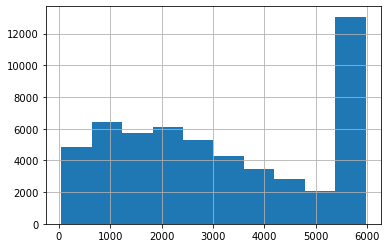

In [16]:
df_query['len_cdna'].hist()

In [17]:
df_query['len_cdna'].max()

5970

### prendo un subset di Paris

In [24]:
def load_sample_from_chunk(file_swap_neg, chunksize = 1_000_000, n_count_max = 5, n_samples = 500_000):
    
    count=0
    
    for chunk in pd.read_csv(file_swap_neg,chunksize=chunksize,sep="\t"):    
        if count == 0:
            subset_filtered=chunk.copy(deep=True)
        else:
            subset_filtered=subset_filtered.append(chunk)

        count+=1

        if count == n_count_max:
            break
        
        
    subset_filtered = subset_filtered.sample(n_samples).reset_index(drop = True)
    
    return subset_filtered

def read_and_concatenate_bed_files_paris(directory, list_of_files_to_load, list_of_names, n_samples):
    # List to store individual dataframes
    dataframes = []
    
    # Iterate over all files in the directory
    for _, filename in enumerate(list_of_files_to_load):
        
        
        file_path = os.path.join(directory, filename)
        
        # Read the .bed file into a dataframe
        if 'NegativeBySwap' in filename:
            df = load_sample_from_chunk(file_path, n_samples = n_samples)
        else:
            df = pd.read_csv(file_path, sep='\t')

        # Check and rename columns if necessary
        if 'chrom_1' in df.columns and 'chrom_2' in df.columns:
            df = df.rename(columns={'chrom_1': 'emb_name_1', 'chrom_2': 'emb_name_2'})
            
            
        df['id_pair'] = list_of_names[_]
        df['id_pair'] = df['id_pair'] + '+' + df['emb_name_1'] + '+' + df['emb_name_2'] + '+' + df['start_1'].astype(str) + '+' + df['end_1'].astype(str) + '+' + df['start_2'].astype(str) + '+' + df['end_2'].astype(str)
        
        
        df = df.rename(columns={
            'emb_name_1': 'embedding1name', 
            'emb_name_2': 'embedding2name',
            'start_1': 'start_window1',
            'end_1': 'end_window1',
            'start_2': 'start_window2',
            'end_2': 'end_window2',
        })
        
        dataframes.append(df)
    
    # Concatenate all dataframes into one
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    
    concatenated_df = concatenated_df.drop('Unnamed: 0', axis = 1) 
    
    concatenated_df = concatenated_df.drop_duplicates()

    # devo droppare tutti quelli che non iniziano per ens
    concatenated_df['ens_gene'] = concatenated_df['embedding1name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)

    concatenated_df['ens_gene'] = concatenated_df['embedding2name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)
    
    return concatenated_df

In [25]:
list_of_files_to_load = [
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__Hela_lowRNase.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__GSM4503872_HEK293_mRNA.bed', 
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__Hela_highRNase.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__HEK293T.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__GSM4503873_Mouse_brain_mRNA.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__HEK293_AMT.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS1__mES.bed',
    'Giorgio.positivi_e_hardneg.no_train_eval.PARIS2__HEK293_Amoto.bed',
    
    'Giorgio.NegativeBySwap.mm_PARIS1__mES.embedding.bed',
    'Giorgio.NegativeBySwap.hs_PARIS1__Hela_highRNase.embedding.bed',
    'Giorgio.NegativeBySwap.hs_PARIS2__GSM4503872_HEK293_mRNA.embedding.bed',
    'Giorgio.NegativeBySwap.hs_PARIS2__HEK293_AMT.embedding.bed',
    'Giorgio.NegativeBySwap.hs_PARIS1__Hela_lowRNase.embedding.bed',
    'Giorgio.NegativeBySwap.hs_PARIS1__HEK293T.embedding.bed',
]
list_of_names = ['paris' for i in range(len(list_of_files_to_load))]

In [32]:
n_samples_for_each_file = 1_000_000

df = read_and_concatenate_bed_files_paris(original_data_path, list_of_files_to_load, list_of_names, n_samples_for_each_file)

assert df[df.id_pair.duplicated()].shape[0] == 0

In [33]:
(3.5 * df.shape[0]) / 400_000

16.6742275

In [34]:
df.to_csv(os.path.join(check_data_path, 'pairs.csv'), index = False)

### prendo un subset di Ricseq

In [30]:
def read_and_concatenate_bed_files(directory, list_of_files_to_load, list_of_names):
    # List to store individual dataframes
    dataframes = []
    
    # Iterate over all files in the directory
    for _, filename in enumerate(list_of_files_to_load):
        file_path = os.path.join(directory, filename)
        # Read the .bed file into a dataframe
        df = pd.read_csv(file_path, sep='\t')

        # Check and rename columns if necessary
        if 'chrom_1' in df.columns and 'chrom_2' in df.columns:
            df = df.rename(columns={'chrom_1': 'emb_name_1', 'chrom_2': 'emb_name_2'})
            
            
        df['id_pair'] = list_of_names[_]
        df['id_pair'] = df['id_pair'] + '+' + df['emb_name_1'] + '+' + df['emb_name_2'] + '+' + df['start_1'].astype(str) + '+' + df['end_1'].astype(str) + '+' + df['start_2'].astype(str) + '+' + df['end_2'].astype(str)
        
        
        df = df.rename(columns={
            'emb_name_1': 'embedding1name', 
            'emb_name_2': 'embedding2name',
            'start_1': 'start_window1',
            'end_1': 'end_window1',
            'start_2': 'start_window2',
            'end_2': 'end_window2',
        })
        
        dataframes.append(df)
    
    # Concatenate all dataframes into one
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    
    concatenated_df = concatenated_df.drop('Unnamed: 0', axis = 1) 
    
    concatenated_df = concatenated_df.drop_duplicates()

    # devo droppare tutti quelli che non iniziano per ens
    concatenated_df['ens_gene'] = concatenated_df['embedding1name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)

    concatenated_df['ens_gene'] = concatenated_df['embedding2name'].str.startswith('ENS')
    concatenated_df = concatenated_df[concatenated_df.ens_gene].reset_index(drop = True)
    concatenated_df = concatenated_df.drop('ens_gene', axis = 1)
    
    return concatenated_df


list_of_files_to_load = os.listdir(original_data_path) # Questo è per tutti i dati
list_of_files_to_load = ['Giorgio.positivi_e_hardneg.no_train_eval.RIC-seq__HeLa_merge.InterGene.arms.bed', 'Giorgio.NegativeBySwap.hs_RIC-seq__HeLa_merge.InterGene.arms.embedding.bed']
list_of_names=['ricseq_pos_hn', 'ricseq_swap_neg']

df = read_and_concatenate_bed_files(original_data_path, list_of_files_to_load, list_of_names)

assert df[df.id_pair.duplicated()].shape[0] == 0

In [36]:
df.to_csv(os.path.join(check_data_path, 'pairs.csv'), index = False)

In [32]:
# n_samples = 500_000

# pos_hn = df[df.id_pair.str.startswith('ricseq_pos_hn')]

# swap_neg = df[df.id_pair.str.startswith('ricseq_swap_neg')].sample(n_samples//2)

# subset = pd.concat([
#     pos_hn.sample(min(pos_hn.shape[0], n_samples//2)), 
#     swap_neg.sample(min(swap_neg.shape[0], n_samples//2)), 
# ], axis = 0)

# subset.to_csv(os.path.join(check_data_path, 'pairs.csv'), index = False)

# subset.shape[0], pos_hn.shape[0], swap_neg.shape[0]

# subset.id_pair.iloc[0]

In [38]:
df.id_pair.iloc[0]

'ricseq_pos_hn+ENST00000000233_1+ENST00000262960_1+28+78+2188+2238'